# Visualisation plots

This notebook generates all plots used in the paper.

## Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tabular_data_experiments.results.plots import (
    plot_incumbent_on_dataset_id,
    plot_cd_diagram_on_dataset_collections,
    plot_parallel_coordinates_plot,
    get_rank_per_collection_for_metrics,
    plot_pcp_metrics,
    plot_rank_random_sets,
)
from tabular_data_experiments.results.utils import (
    get_citation_style,
    get_order_of_labels_correlation,
    get_order_of_labels_median_collection_size,
    load_results,
    ranks_by_frequency,
    ranks_random_sets,
    get_results_after_cutoff
)
from tabular_data_experiments.results.result import ConfigSplitResults
from tabular_data_experiments.results.constants import (
    FINAL_MODELS,
    FINAL_LABEL_NAMES,
    MODELS_TO_COLORS,
    MissingResultsHandler,
    dataset_collections,
)
from tabular_data_experiments.utils.suites import COLLECTION_KEYS, CUSTOM_SUITES
from pathlib import Path

## Define Constants

In [2]:
PATH_TO_RESULTS = Path('/home/matthias/projects/2023_tabular_data/results_release/csv_files')  # TODO change this to match your result directory.
RESULTS_DIR = Path("final_results")
MODEL_RESULTS_DIR = PATH_TO_RESULTS / "new_results"
TABLES_DIR = RESULTS_DIR / "tables"
RESULTS_DIR.mkdir(exist_ok=True, parents=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)
metrics = ["roc_auc", "balanced_accuracy", "roc_auc_ovr", "accuracy"]
collection_mapping = {
    c: get_citation_style(c) for c in COLLECTION_KEYS
}
suites_to_plot = list(set(COLLECTION_KEYS) - set("grinsztajn-neuripsdbt22a_unpreprocessed"))
suites_left = [
        "bischl-neuripsdbt21a", # openml-cc18
        "gijsbers-arxiv22a", # automlbenchmark
]

suites_right = list(
    set(suites_to_plot)
    - set(suites_left)
)

current_collections_datasets = {c: dataset_collections[c] for c in suites_to_plot}
current_collections_datasets["all_datasets"] = [str(task_id) for task_id in CUSTOM_SUITES["all_datasets"]]
MISSING_RESULTS_HANDLER = MissingResultsHandler.impute_nan

## Load Results

### Load from CSV

In [3]:
results = load_results(MODEL_RESULTS_DIR, FINAL_MODELS)
results = results.handle_missing_results(missing_value_handler=MISSING_RESULTS_HANDLER)
current_results = results.at(fold=[0], split=[0])

Dropping 0 tasks [] with all nans and keeping 187 tasks


## Get table for roc auc

/home/matthias/sync_dir/projects/2023_cc23_prestudy/tabular_data_experiments_dmlr_code_release/analysis/final_results


/home/matthias/sync_dir/projects/2023_cc23_prestudy/tabular_data_experiments_dmlr_code_release/tabular_data_experiments/results/plots.py:673: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(tl) for tl in ax.get_xticks()], fontsize=26)
/home/matthias/sync_dir/projects/2023_cc23_prestudy/tabular_data_experiments_dmlr_code_release/tabular_data_experiments/results/plots.py:674: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(tl) for tl in ax.get_yticks()], fontsize=26)
/home/matthias/sync_dir/projects/2023_cc23_prestudy/tabular_data_experiments_dmlr_code_release/tabular_data_experiments/results/plots.py:682: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/matthias/sync_dir/projects/2023_cc23_prestudy/tabular_data_experiments_dmlr_code_release/tabular_data_experiments/results/

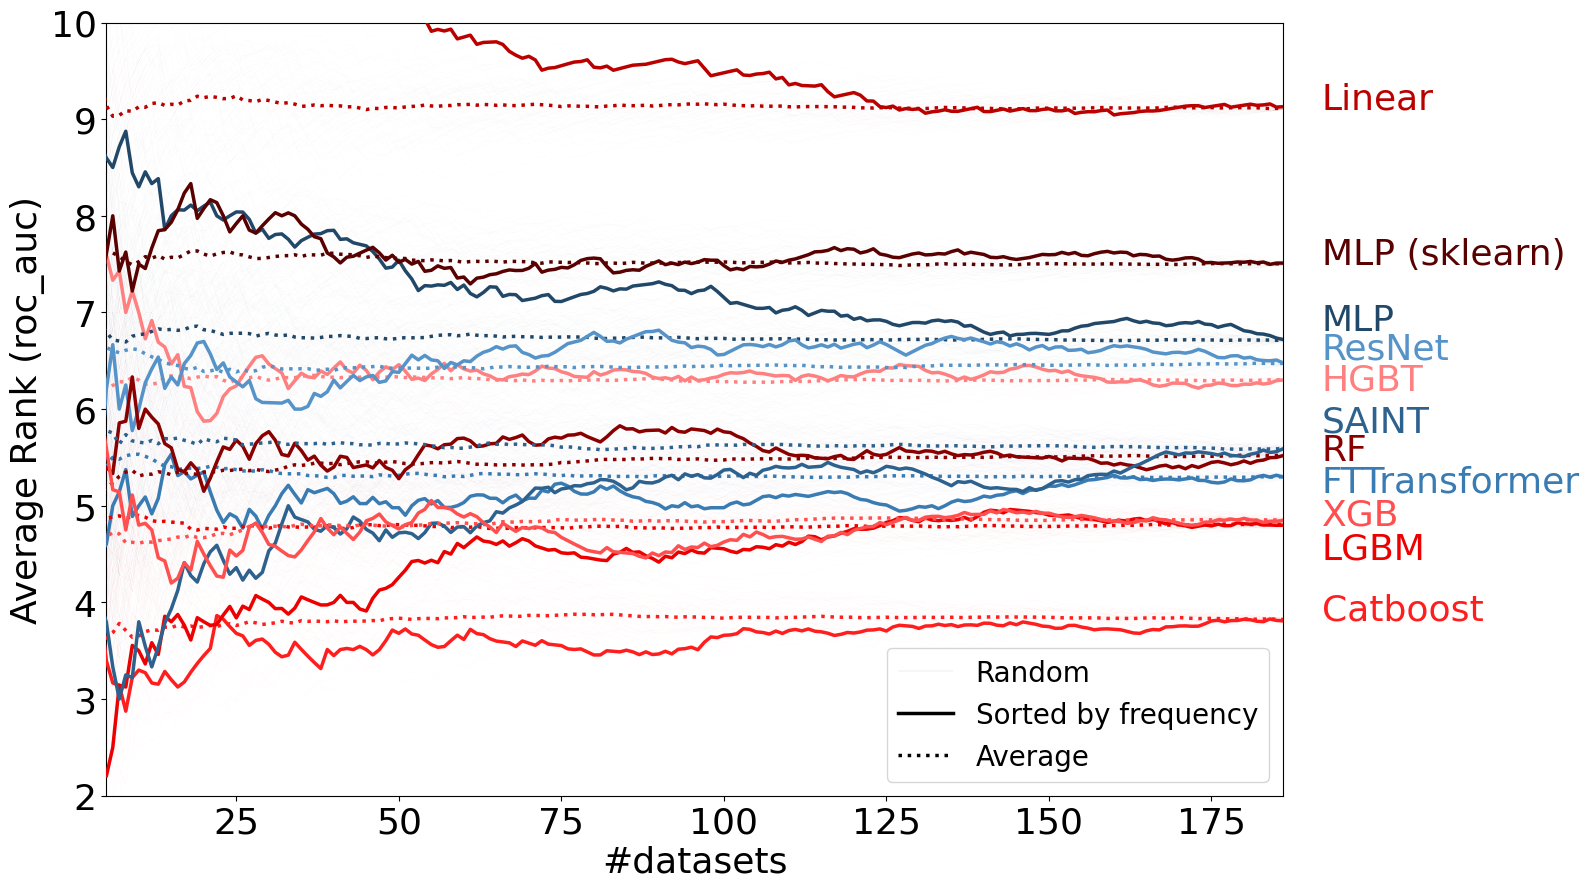

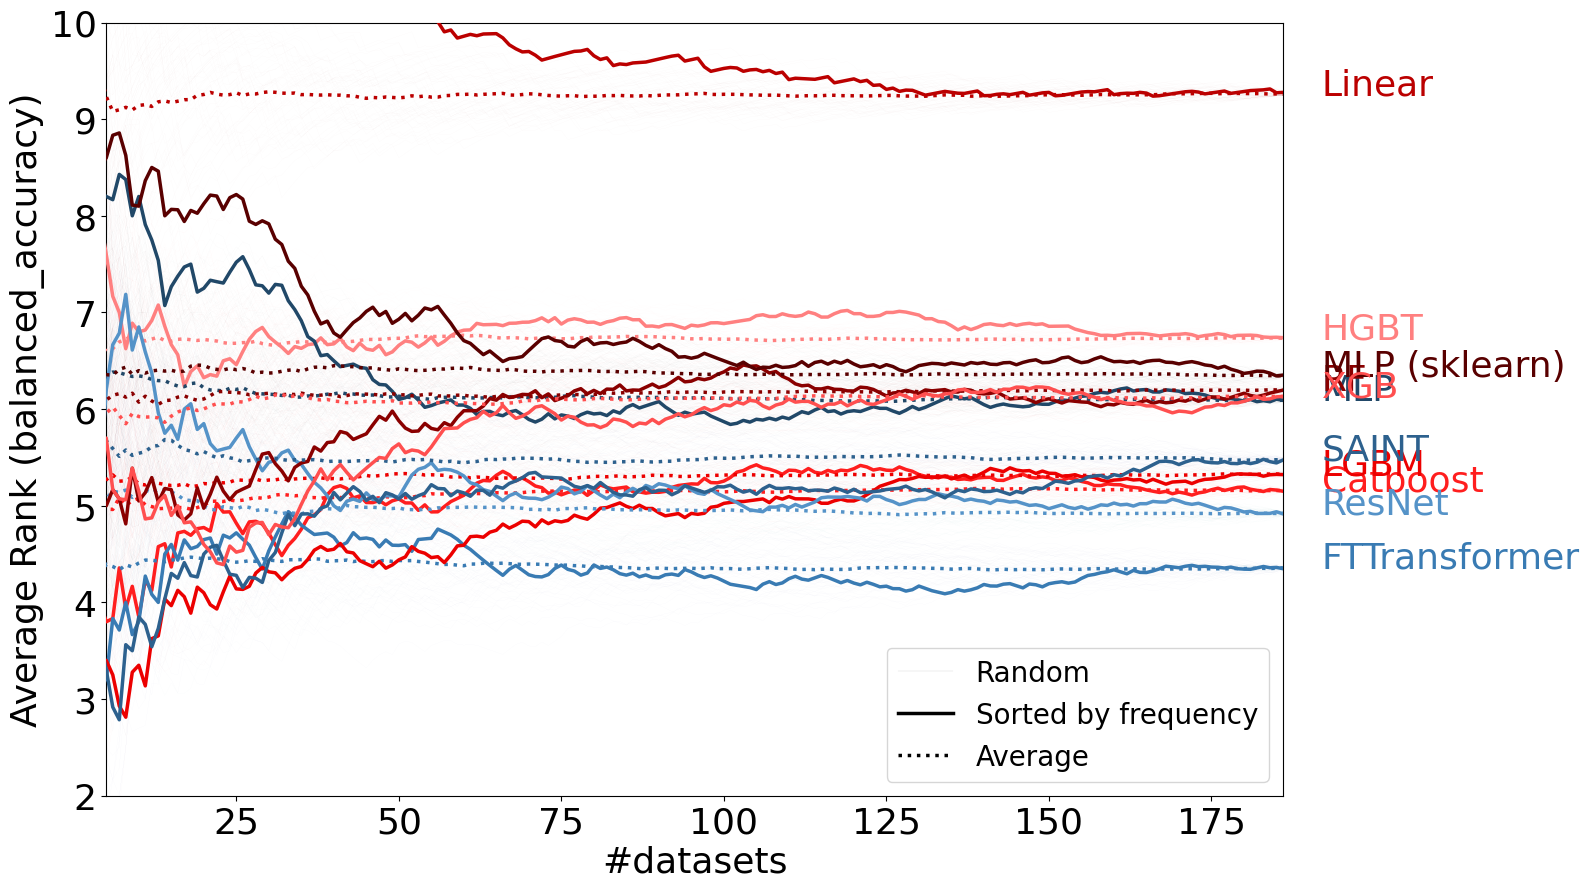

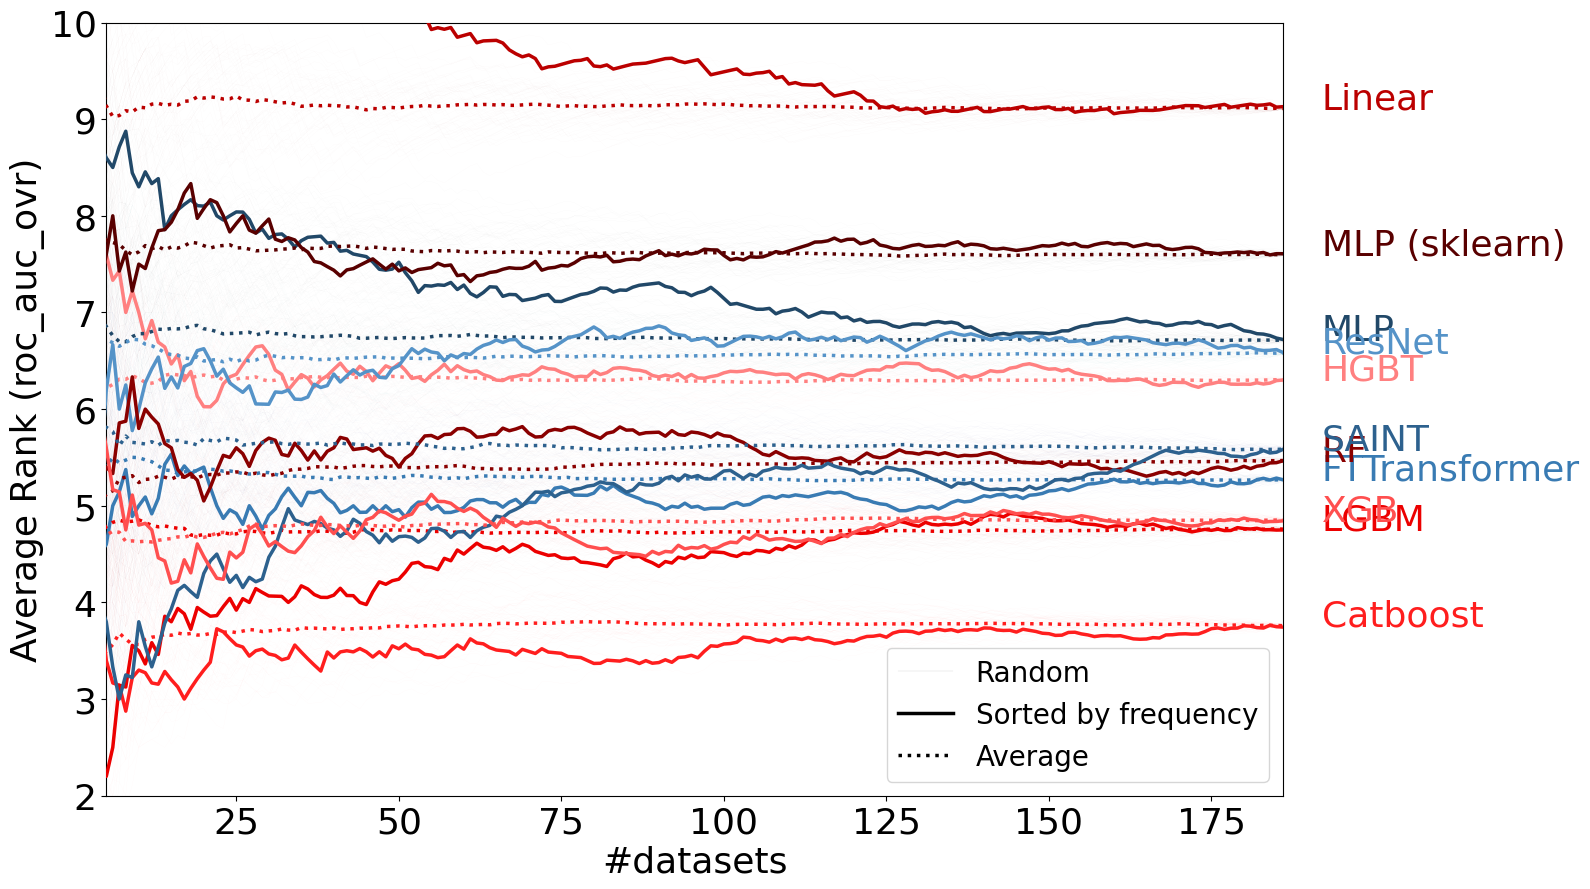

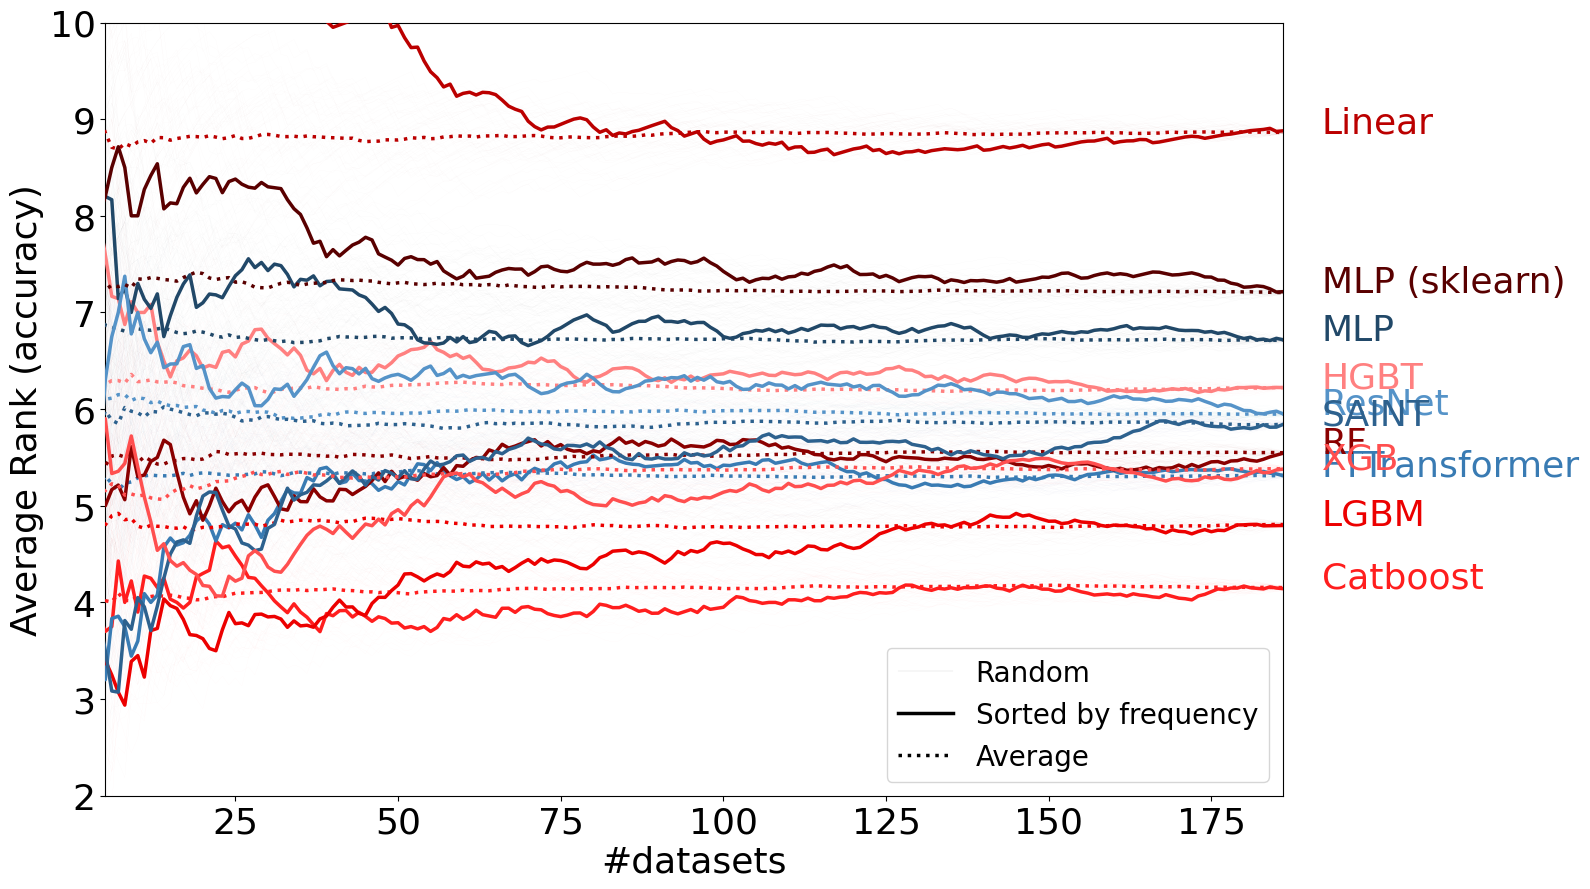

In [4]:
tables_metric = dict()
print(RESULTS_DIR.absolute())

text_y_offset = {}
text_y_offset["roc_auc"] = {
    "hgbt": -0.1,
    "linear": 0,
    "rf": -0.05,
    "catboost_early_stop_valid": 0,
    "xgb_early_stop_valid": -0.05,
    "lgbm_early_stop_valid": -0.35,
    "mlp_early_stop_valid": 0.1,
    "resnet_early_stop_valid": 0.05,
    "ft_transformer_early_stop_valid": -0.15,
    "saint_early_stop_valid": 0.18,
    "sklearn_mlp": 0
}

for metric in metrics:
    tables_metric[metric] = current_results.get_metric_table(metric=metric)
    tables_metric[metric].to_csv(TABLES_DIR / f"metric_{metric}.csv")
    df = tables_metric[metric].T.copy()
    df.index.name = None
    df.columns = [int(c) for c in df.columns]
    tasks = df.columns
    frequency_rank, dataset_frequency = ranks_by_frequency(df, task_dc=current_collections_datasets, tasks=tasks)

    all_res = ranks_random_sets(df, seed=1, tasks=tasks)

    plot_rank_random_sets(
        all_res=all_res,
        frequency_rank=frequency_rank,
        metric=metric,
        tasks=tasks,
        n_rep=50,
        results_dir = RESULTS_DIR / "random_sets",
        y_lim=(2.0, 10.0),
        text_y_offset=text_y_offset,
        random_shuffle_alpha=0.1
    )


# Get rank over age

In [5]:
metric = "roc_auc"
final_results = current_results.get_metric_table(metric=metric)

In [6]:
print(final_results.columns)
final_results_subset = final_results[FINAL_MODELS]

Index(['catboost_early_stop_valid', 'ft_transformer_early_stop_valid', 'hgbt',
       'lgbm_early_stop_valid', 'linear', 'mlp_early_stop_valid',
       'resnet_early_stop_valid', 'rf', 'saint_early_stop_valid',
       'sklearn_mlp', 'xgb_early_stop_valid'],
      dtype='object', name='method')


In [7]:
import openml
all_task_ids = [int(task_id) for task_id in final_results_subset.index]
all_tasks_on_openml = openml.tasks.list_tasks(task_type=openml.tasks.TaskType.SUPERVISED_CLASSIFICATION)
task_id_to_dataset_id = {task_id: all_tasks_on_openml[task_id]["did"] for task_id in all_task_ids}
dataset_id_to_task_id = {dataset_id: task_id for task_id, dataset_id in task_id_to_dataset_id.items()}
dataset_id_to_dataset_name = {dataset_id: all_tasks_on_openml[task_id]["name"] for dataset_id, task_id in dataset_id_to_task_id.items()}

In [8]:
from tabular_data_experiments.results.hardness import get_age
AGE_FILE = PATH_TO_RESULTS  / "year_info.csv"
age = get_age(AGE_FILE)

In [9]:
all_ranks = []
for _, (dataset_id, year) in age.iterrows():
    task_id = dataset_id_to_task_id[dataset_id]
    results_for_task = final_results_subset.loc[str(task_id)]
    ranks_for_task = results_for_task.rank(ascending=False)
    all_ranks.append(ranks_for_task)
all_ranks = pd.DataFrame(all_ranks).transpose()

hgbt -.
linear -
rf -
catboost_early_stop_valid --
xgb_early_stop_valid :
lgbm_early_stop_valid -
mlp_early_stop_valid --
resnet_early_stop_valid -.
ft_transformer_early_stop_valid -
saint_early_stop_valid :
sklearn_mlp -


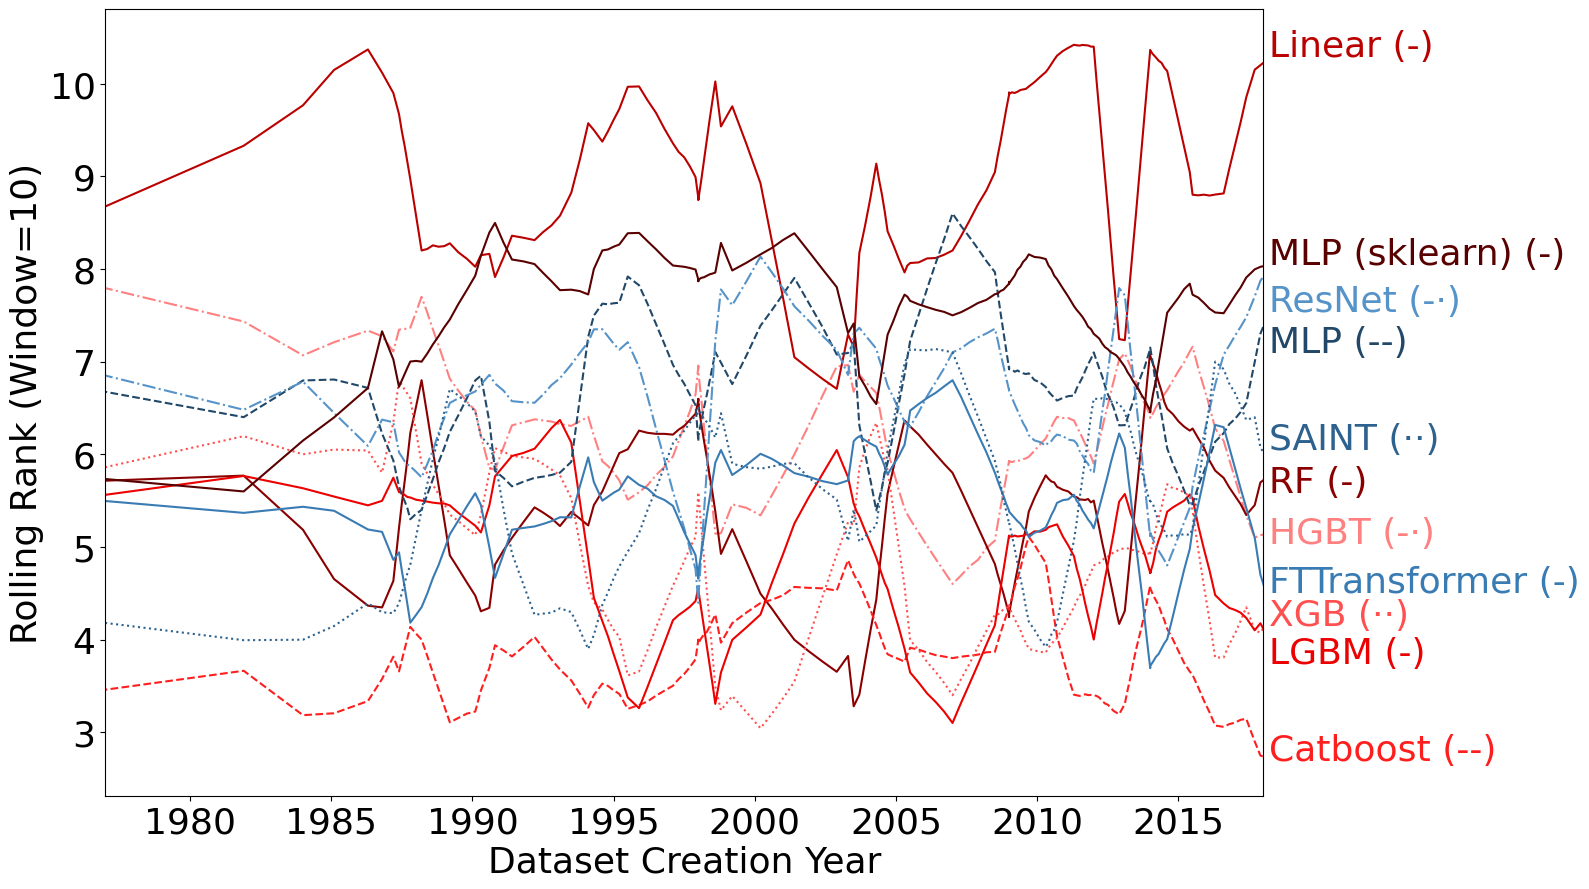

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

window_size = 10
rolling_results = None
all_ages = None
for i in range(1000):
    shuffled_age = age.sample(frac=1, random_state=i)
    sorted_age = shuffled_age.sort_values(by="age")
    sorted_dataset_ids = sorted_age["dataset_id"]
    tasks_sorted_by_age_shuffled = [str(dataset_id_to_task_id[dataset_id]) for dataset_id in sorted_dataset_ids]
    rr = all_ranks[tasks_sorted_by_age_shuffled].rolling(window_size, axis=1).mean()
    ages = sorted_age["age"].rolling(window_size).mean()
    if rolling_results is None:
        rolling_results = rr.to_numpy()
        all_ages = ages.to_numpy()
    else:
        rolling_results += rr.to_numpy()
        all_ages += ages.to_numpy()
rolling_results = rolling_results / 1000
all_ages = all_ages / 1000

text_y_offset = {
    "hgbt": -0.1,
    "linear": 0,
    "rf": -0.2,
    "catboost_early_stop_valid": 0,
    "xgb_early_stop_valid": -0.1,
    "lgbm_early_stop_valid": -0.2,
    "mlp_early_stop_valid": -0.5,
    "resnet_early_stop_valid": -0.5,
    "ft_transformer_early_stop_valid": 0.2,
    "saint_early_stop_valid": 0.2,
    "sklearn_mlp": 0
}

linestyles = {
    "hgbt": "-.",
    "linear": "-",
    "rf": "-",
    "catboost_early_stop_valid": "--",
    "xgb_early_stop_valid": ":",
    "lgbm_early_stop_valid": "-",
    "mlp_early_stop_valid": "--",
    "resnet_early_stop_valid": "-.",
    "ft_transformer_early_stop_valid": "-",
    "saint_early_stop_valid": ":",
    "sklearn_mlp": "-"
}

for method, perf in zip(all_ranks.index, rolling_results):
    print(method, linestyles[method])
    color = MODELS_TO_COLORS[method]
    ax.plot(list(all_ages), perf, label=method, color=color, linestyle=linestyles[method])
    ax.text(2018.2, perf[-1] + text_y_offset[method], 
            FINAL_LABEL_NAMES[method] + f" ({linestyles[method].replace('.', '·').replace(':', '··')})", 
            fontsize=26, c=color)

ax.set_xlim((1977, 2018))
ax.set_xlabel("Dataset Creation Year", fontsize=26)
ax.set_ylabel("Rolling Rank (Window=10)", fontsize=26)
ax.tick_params(axis='both', labelsize=26)
fig.tight_layout()
fig.savefig("/tmp/rolling_rank_over_dataset_age.pdf")
fig.savefig("/tmp/rolling_rank_over_dataset_age.png")

[5, 41, 4, 5, 37, 17, 30, 19, 10, 15, 10, 16, 13, 61, 7, 14, 14, 18, 22, 9, 10, 13, 27, 20, 39, 17, 10, 10, 61, 17, 181, 618, 20, 31, 37, 6, 257, 10, 40, 17, 21, 43, 27, 65, 42, 15, 15, 16, 9, 9, 14, 1559, 48, 280, 7, 65, 11, 55, 21, 55, 241, 280, 77, 28, 785, 124, 217, 9, 8, 9, 42, 58, 12, 86, 11, 260, 10001, 501, 71, 5, 22, 22, 22, 11, 22, 38, 38, 73, 21, 7, 24, 28, 51, 7, 5, 181, 1637, 49, 971, 2001, 8, 119, 5, 48, 8, 145, 22, 21, 14892, 4, 231, 3073, 24, 857, 25, 12, 309, 55, 19, 9, 8, 28, 7201, 55, 1777, 8, 11, 20, 420, 17, 11, 12, 12, 130, 12, 21, 10001, 562, 31, 5, 33, 10, 5, 1301, 52, 801, 42, 21, 137, 6, 33, 13, 29, 79, 7, 61, 25, 32, 50, 29, 29, 129, 2001, 31, 31, 94, 82, 1025, 37, 33, 12, 171, 14, 117, 22, 4297, 4297, 785, 58, 121, 20, 24, 18, 9, 11, 201, 7]
[150, 5500, 306, 625, 3196, 435, 3772, 846, 214, 690, 1473, 690, 990, 208, 1728, 303, 270, 339, 1728, 768, 286, 1066, 368, 2310, 898, 13488, 958, 699, 3190, 20000, 3186, 7797, 736, 569, 6430, 5404, 1593, 58000, 540, 1099

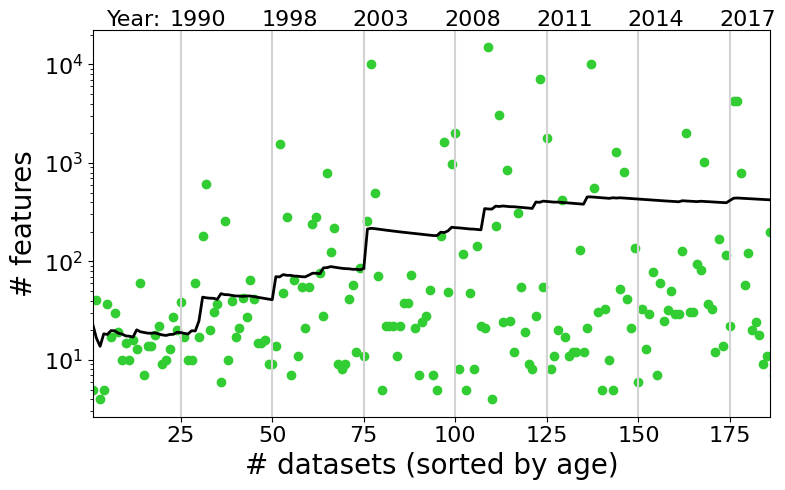

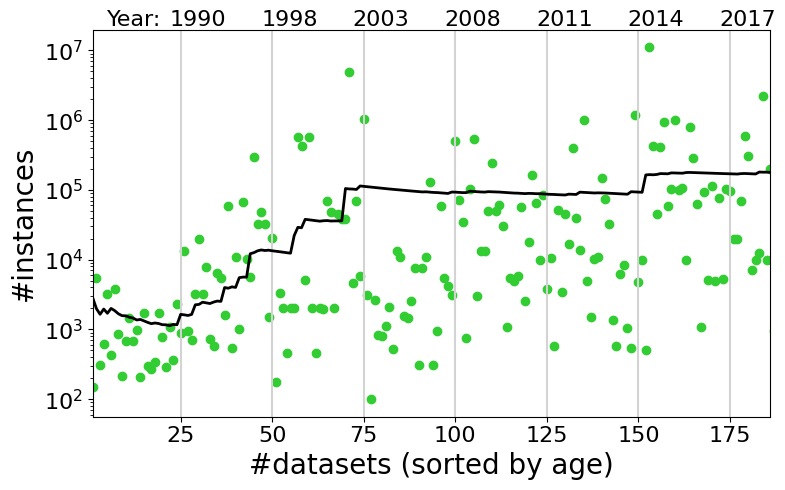

In [11]:
iteration = 0
features_over_time = []
instances_over_time = []
years = []
for _, (dataset_id, dataset_age) in age.iterrows():
    iteration += 1
    task_id = dataset_id_to_task_id[dataset_id]
    features_over_time.append(all_tasks_on_openml[task_id]["NumberOfFeatures"])
    instances_over_time.append(all_tasks_on_openml[task_id]["NumberOfInstances"])
    years.append(dataset_age)
print((features_over_time))
print((instances_over_time))
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

for vertical in (25, 50, 75, 100, 125, 150, 175):
    ax.annotate(years[vertical], xy=(vertical - 3, 1.01), xycoords=("data", "axes fraction"), fontsize=16)
    ax.axvline(x=vertical, color='lightgray')
ax.annotate("Year:", xy=(5, 1.01), xycoords=("data", "axes fraction"), fontsize=16)

ax.plot(np.cumsum(features_over_time) / np.arange(1, len(features_over_time) + 1, 1), color="k", linewidth=2)
ax.scatter(np.arange(1, len(features_over_time) + 1, 1), np.minimum(features_over_time, features_over_time), color="limegreen")
ax.set_xlim((1, len(features_over_time) - 1))
ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel("# datasets (sorted by age)", fontsize=20)
ax.set_ylabel("# features", fontsize=20)
ax.set_yscale("log")
#tikzplotlib.save("/tmp/features.tex")
fig.tight_layout()
plt.savefig("/tmp/features.pdf")
plt.savefig("/tmp/features.png")

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

for vertical in (25, 50, 75, 100, 125, 150, 175):
    ax.annotate(years[vertical], xy=(vertical - 3, 1.01), xycoords=("data", "axes fraction"), fontsize=16)
    ax.axvline(x=vertical, color='lightgray')
ax.annotate("Year:", xy=(5, 1.01), xycoords=("data", "axes fraction"), fontsize=16)

ax.plot(np.cumsum(instances_over_time) / np.arange(1, len(instances_over_time) + 1, 1), color="k", linewidth=2)
ax.scatter(np.arange(1, len(instances_over_time) + 1, 1), np.minimum(instances_over_time, instances_over_time), color="limegreen")
ax.set_xlim((1, len(instances_over_time) - 1))
ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel("#datasets (sorted by age)", fontsize=20)
ax.set_ylabel("#instances", fontsize=20)
ax.set_yscale("log")
fig.tight_layout()
#tikzplotlib.save("/tmp/instances.tex")
plt.savefig("/tmp/instances.pdf")
plt.savefig("/tmp/instances.png")

/tmp/ipykernel_414126/755063660.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.ecdfplot(data=age, x="age", palette="viridis", ax=ax, linewidth=2, color="k")


0.25/0.5/0.75 Quantiles
1996.0 2005.0 2012.0


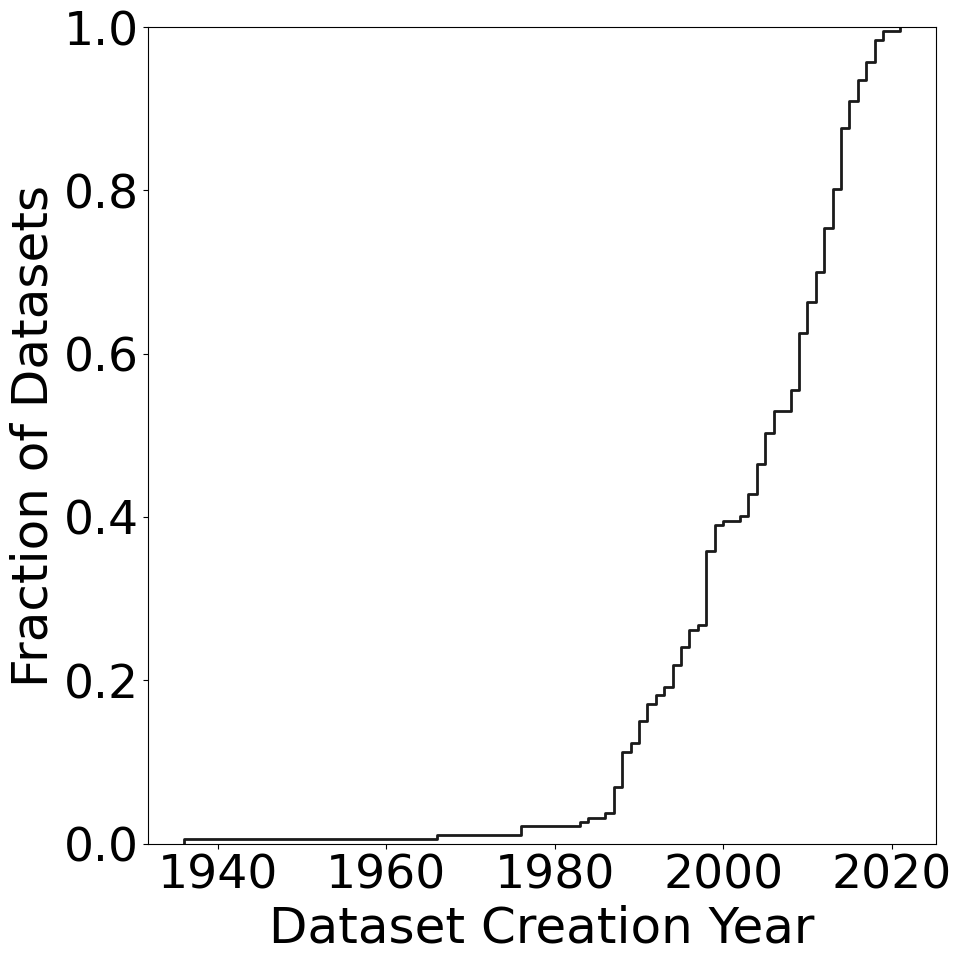

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=2)
ax = sns.ecdfplot(data=age, x="age", palette="viridis", ax=ax, linewidth=2, color="k")
ax.set_xlabel("Dataset Creation Year", fontsize=36)
ax.set_ylabel(f"Fraction of Datasets", fontsize=36)
ax.tick_params(axis='both', labelsize=34)
fig.tight_layout()
fig.savefig("/tmp/cdf_age.pdf")
fig.savefig("/tmp/cdf_age.png")

print("0.25/0.5/0.75 Quantiles")
print(age["age"].quantile(0.25), age["age"].quantile(0.5), age["age"].quantile(0.75))